# <center>CNN Histopathologic Cancer Detection</center>
## <div style="text-align:right;"> ----5511 Week3 Project

## 1. Project Topic
### 1.1. Convolutional Neural Network (CNN)
A Convolutional Neural Network (CNN) is a type of deep learning model designed for processing structured grids of data, such as images. It applies convolutional operations to extract features hierarchically, preserving spatial relationships. By combining these features through layers of convolutions, pooling, and fully connected layers, CNNs can effectively learn representations that are robust for tasks like image classification, object detection, and segmentation.
### 1.2. Project goal
In this project, I will create an Convolutional Neural Network (CNN) to identify metastatic cancer in small image patches taken from larger digital pathology scans. 

## 2. Data Overview

In this dataset, we are provided with a large number of small pathology images to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. We are predicting the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.


In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import copy
import os
import torch
from PIL import Image
from PIL import Image, ImageDraw
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
%matplotlib inline

In [2]:
# load the data
labels_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

In [34]:
labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [35]:
labels_df.shape

(220025, 2)

In [61]:
labels_df.describe()

,label
count,57458.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [62]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57458 entries, 0 to 57457
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      57458 non-null  object
 1   label   57458 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 897.9+ KB


Data size: 897.9+ KB

Data dimensions: 2 columns and 57458 entries

Data type: int64 and object

In [36]:
# Check duplicate values
labels_df[labels_df.duplicated(keep=False)]

,id,label


No duplicate values found 

In [37]:
# check data balance
labels_df['label'].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

The dataset favours `non-malignant` cases (label = 0, 13.1k cases), compared to `malignant` cases (label = 1, 8.9k cases)

## 3. Exploratory Data Analysis

Let us first get the IDs of malignant cases and normal cases, respectively, and display some of them.

In [38]:
imgpath ="/kaggle/input/histopathologic-cancer-detection/train/" # training data is stored in this folder
malignant = labels_df.loc[labels_df['label']==1]['id'].values    # get the ids of malignant cases
normal = labels_df.loc[labels_df['label']==0]['id'].values       # get the ids of the normal cases

print('normal ids')
print(normal[0:5],'\n')

print('malignant ids')
print(malignant[0:5])

normal ids
['f38a6374c348f90b587e046aac6079959adf3835'
 '755db6279dae599ebb4d39a9123cce439965282d'
 'bc3f0c64fb968ff4a8bd33af6971ecae77c75e08'
 '068aba587a4950175d04c680d38943fd488d6a9d'
 'acfe80838488fae3c89bd21ade75be5c34e66be7'] 

malignant ids
['c18f2d887b7ae4f6742ee445113fa1aef383ed77'
 'a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da'
 '7f6ccae485af121e0b6ee733022e226ee6b0c65f'
 'c3d660212bf2a11c994e0eadff13770a9927b731'
 '94fa32b29cc1c00403176c0795fffa3cfaa0f20e']


Next, I will try to display some images in the maligant class and normal class, respectively

In [39]:
# write a function to display the images
def plot_fig(ids,title,nrows=3,ncols=9):

    fig,ax = plt.subplots(nrows,ncols,figsize=(18,6))
    plt.subplots_adjust(wspace=0, hspace=0) 
    for i,j in enumerate(ids[:nrows*ncols]):
        fname = os.path.join(imgpath ,j +'.tif')
        img = Image.open(fname)
        idcol = ImageDraw.Draw(img)
        idcol.rectangle(((0,0),(95,95)),outline='white')
        plt.subplot(nrows, ncols, i+1) 
        plt.imshow(np.array(img))
        plt.axis('off')

    plt.suptitle(title, y=0.94)

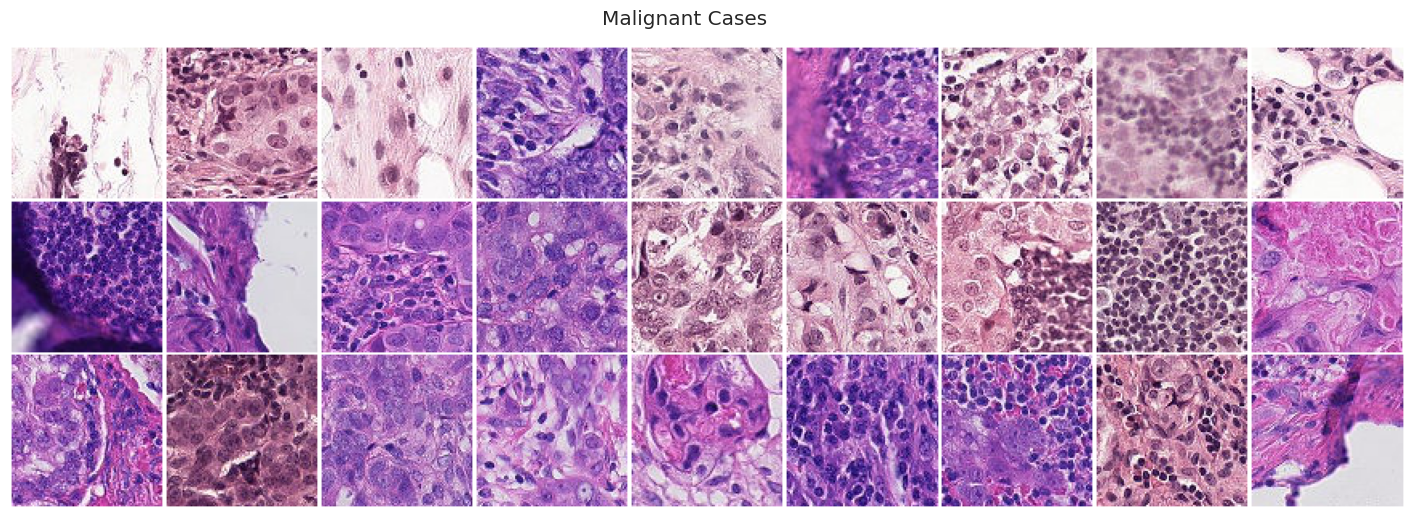

In [40]:
plot_fig(malignant,'Malignant Cases')

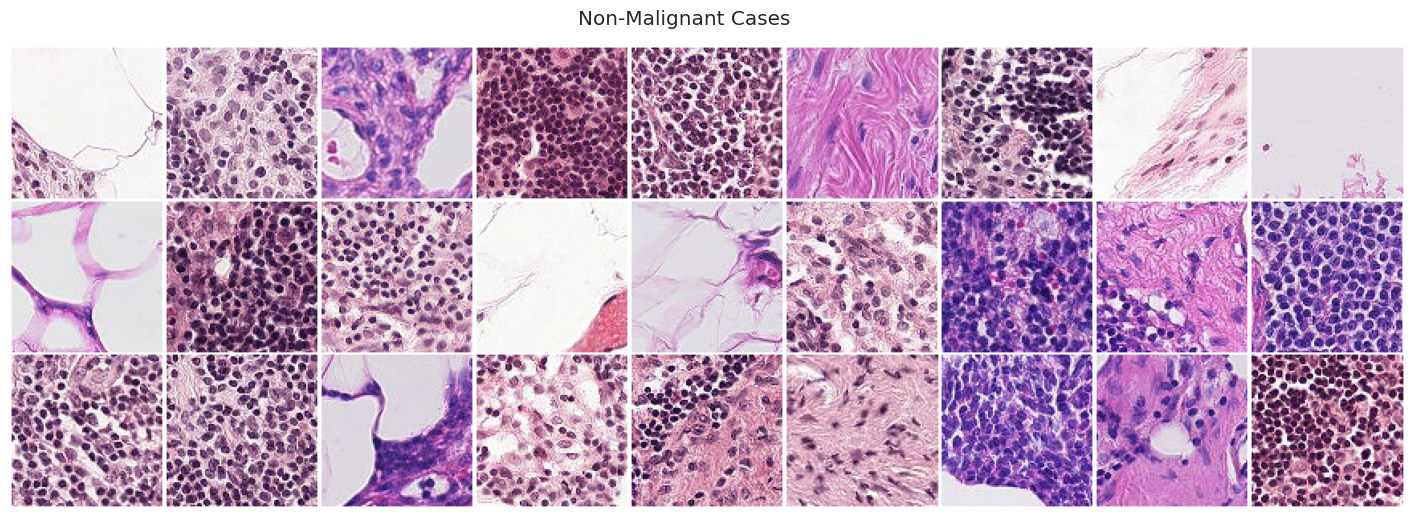

In [41]:
plot_fig(normal,'Non-Malignant Cases')

Based on the above images, we can observe significant variations both within and between groups, and I am unable to tell any difference between Malignant vs. Non-malignant class.

Next, I will visualize the balance of the data and check the number of malignant cases as well as number of non-malignant cases.

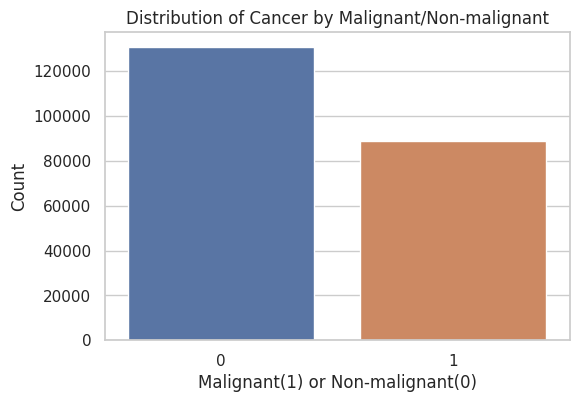

In [43]:
import seaborn as sns

plt.figure(figsize = (6,4))
sns.countplot(x = 'label', data = labels_df)
plt.title('Distribution of Cancer by Malignant/Non-malignant')
plt.xlabel('Malignant(1) or Non-malignant(0)')
plt.ylabel('Count')
plt.show()

## 4. Data preprocessing

### 4.1. Create `Dataset` Class
In this step, I will create a custom `Dataset` class, and to speed up the training process, I will use 4000 samples for the entire dataset.

In [9]:
torch.manual_seed(0) 

class pytorch_data(Dataset):
    
    def __init__(self,data_dir,transform,data_type="train"):      
    
        # Get Image File Names
        cdm_data=os.path.join(data_dir,data_type)  # directory of files
        
        file_names = os.listdir(cdm_data) # get list of images in that directory  
        idx_choose = np.random.choice(np.arange(len(file_names)), 
                                      4000,
                                      replace=False).tolist()
        file_names_sample = [file_names[x] for x in idx_choose]
        self.full_filenames = [os.path.join(cdm_data, f) for f in file_names_sample]   # get the full path to images
        
        # Get Labels
        labels_data=os.path.join(data_dir,"train_labels.csv") 
        labels_df=pd.read_csv(labels_data)
        labels_df.set_index("id", inplace=True) # set data frame index to id
        self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in file_names_sample]  # obtained labels from df
        self.transform = transform
      
    def __len__(self):
        return len(self.full_filenames) # size of dataset
      
    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        image = Image.open(self.full_filenames[idx])  # Open Image with PIL
        image = self.transform(image) # Apply Specific Transformation to Image
        return image, self.labels[idx]


In [10]:
# define transformation that converts a PIL image into PyTorch tensors
import torchvision.transforms as transforms
data_transformer = transforms.Compose([transforms.ToTensor(),
                                       transforms.Resize((46,46))])

In [11]:
# Define an object of the custom dataset for the train folder.
data_dir = '/kaggle/input/histopathologic-cancer-detection/'
img_dataset = pytorch_data(data_dir, data_transformer, "train") # Histopathalogic images

### 4.2. Split the Dataset

Here I will use a 80/20 split.

In [13]:
len_img=len(img_dataset)
len_train=int(0.8*len_img)
len_val=len_img-len_train

# Split Pytorch tensor
train_ts,val_ts=random_split(img_dataset,
                             [len_train,len_val]) # random split 80/20

print("train dataset size:", len(train_ts))
print("validation dataset size:", len(val_ts))

train dataset size: 3200
validation dataset size: 800


In [14]:
# getting the torch tensor image & target variable
ii=-1
for x,y in train_ts:
    print(x.shape,y)
    ii+=1
    if(ii>5):
        break

torch.Size([3, 46, 46]) 0
torch.Size([3, 46, 46]) 0
torch.Size([3, 46, 46]) 0
torch.Size([3, 46, 46]) 1
torch.Size([3, 46, 46]) 1
torch.Size([3, 46, 46]) 0
torch.Size([3, 46, 46]) 0


In [15]:
import plotly.express as px

def plot_img(x,y,title=None):

    npimg = x.numpy() # convert tensor to numpy array
    npimg_tr=np.transpose(npimg, (1,2,0)) # Convert to H*W*C shape
    fig = px.imshow(npimg_tr)
    fig.update_layout(template='plotly_white')
    fig.update_layout(title=title,height=300,margin={'l':10,'r':20,'b':10})
    fig.show()

### 4.3. Image Preprocessing


In [18]:
# Define the following transformations for the training dataset
tr_transf = transforms.Compose([
#     transforms.Resize((40,40)),
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomVerticalFlip(p=0.5),  
    transforms.RandomRotation(45),         
#     transforms.RandomResizedCrop(50,scale=(0.8,1.0),ratio=(1.0,1.0)),
    transforms.ToTensor()])

In [19]:
# For the validation dataset, we don't need any augmentation; simply convert images into tensors
val_transf = transforms.Compose([
    transforms.ToTensor()])

# After defining the transformations, overwrite the transform functions of train_ts, val_ts
train_ts.transform=tr_transf
val_ts.transform=val_transf

### 4.4. Create Dataloader

In [21]:
from torch.utils.data import DataLoader

# Training DataLoader
train_dl = DataLoader(train_ts,
                      batch_size=32, 
                      shuffle=True)

# Validation DataLoader
val_dl = DataLoader(val_ts,
                    batch_size=32,
                    shuffle=False)

## 5. Model Architecure

### 5.1. Construct the Model

The model that I will be using is comprised of:
* Four CNN Conv2D layers with a pooling layer max_pool2D added between each layer
* Two fully connected layers fc, with a dropout layer between the two layers
* log_softmax is used as the activation function for the final layer of the binary classifier

In [23]:
def findConv2dOutShape(hin,win,conv,pool=2):
    # get conv arguments
    kernel_size=conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        hout/=pool
        wout/=pool
    return int(hout),int(wout)

import torch.nn as nn
import torch.nn.functional as F

# Neural Network
class Network(nn.Module):
    
    # Network Initialisation
    def __init__(self, params):
        
        super(Network, self).__init__()
    
        Cin,Hin,Win=params["shape_in"]
        init_f=params["initial_filters"] 
        num_fc1=params["num_fc1"]  
        num_classes=params["num_classes"] 
        self.dropout_rate=params["dropout_rate"] 
        
        # Convolution Layers
        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
        h,w=findConv2dOutShape(Hin,Win,self.conv1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv2)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv3)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv4)
        
        # compute the flatten size
        self.num_flatten=h*w*8*init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self,X):
        
        # Convolution & Pool Layers
        X = F.relu(self.conv1(X)); 
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X, 2, 2)

        X = X.view(-1, self.num_flatten)
        
        X = F.relu(self.fc1(X))
        X=F.dropout(X, self.dropout_rate)
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)

In [24]:
# Neural Network Predefined Parameters
params_model={
        "shape_in": (3,46,46), 
        "initial_filters": 8,    
        "num_fc1": 100,
        "dropout_rate": 0.25,
        "num_classes": 2}

# Create instantiation of Network class
cnn_model = Network(params_model)

# define computation hardware approach (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = cnn_model.to(device)

### 5.2. Train the Model (Hyperparameter Tuning and Optimization)

In [26]:
loss_func = nn.NLLLoss(reduction="sum")

In [27]:
from torch import optim
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

In [28]:
# Function to get the learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt=None):
    
    loss = loss_func(output, target) # get loss
    pred = output.argmax(dim=1, keepdim=True) # Get Output Class
    metric_b=pred.eq(target.view_as(pred)).sum().item() # get performance metric
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

# Compute the loss value & performance metric for the entire dataset (epoch)
def loss_epoch(model,loss_func,dataset_dl,opt=None):
    
    run_loss=0.0 
    t_metric=0.0
    len_data=len(dataset_dl.dataset)

    # internal loop over dataset
    for xb, yb in dataset_dl:
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb) # get model output
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt) # get loss per batch
        run_loss+=loss_b        # update running loss

        if metric_b is not None: # update running metric
            t_metric+=metric_b    
    
    loss=run_loss/float(len_data)  # average loss value
    metric=t_metric/float(len_data) # average metric value
    
    return loss, metric

In [29]:
params_train={
 "train": train_dl,"val": val_dl,
 "epochs": 50,
 "optimiser": optim.Adam(cnn_model.parameters(),
                         lr=3e-4),
 "lr_change": ReduceLROnPlateau(opt,
                                mode='min',
                                factor=0.5,
                                patience=20,
                                verbose=0),
 "f_loss": nn.NLLLoss(reduction="sum"),
 "weight_path": "weights.pt",
 "check": False, 
}


In [30]:
from tqdm.notebook import trange, tqdm

def train_val(model, params,verbose=False):
    
    # Get the parameters
    epochs=params["epochs"]
    loss_func=params["f_loss"]
    opt=params["optimiser"]
    train_dl=params["train"]
    val_dl=params["val"]
    lr_scheduler=params["lr_change"]
    weight_path=params["weight_path"]
    
    loss_history={"train": [],"val": []} # history of loss values in each epoch
    metric_history={"train": [],"val": []} # histroy of metric values in each epoch
    best_model_wts = copy.deepcopy(model.state_dict()) # a deep copy of weights for the best performing model
    best_loss=float('inf') # initialize best loss to a large value
    
    ''' Train Model n_epochs '''
    
    for epoch in tqdm(range(epochs)):
        
        ''' Get the Learning Rate '''
        current_lr=get_lr(opt)
        if(verbose):
            print('Epoch {}/{}, current lr={}'.format(epoch, epochs - 1, current_lr))
        
        '''
        
        Train Model Process
        
        '''
        
        model.train()
        train_loss, train_metric = loss_epoch(model,loss_func,train_dl,opt)

        # collect losses
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        '''
        
        Evaluate Model Process
        
        '''
        
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model,loss_func,val_dl)
        
        # store best model
        if(val_loss < best_loss):
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            torch.save(model.state_dict(), weight_path)
            if(verbose):
                print("Copied best model weights!")
        
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if(verbose):
                print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 

        if(verbose):
            print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
            print("-"*10) 

    # load best model weights
    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history

Define the parameters for training `params_train` & train classifier.

I'll be training the classifier for 50 iterations using the Adam optimiser & the negative log likelihood loss function
The learning rate will be adjusted on the fly using ReduceLROnPlateau, with a factor of 1/2.

In [31]:
params_train={
 "train": train_dl,"val": val_dl,
 "epochs": 50,
 "optimiser": optim.Adam(cnn_model.parameters(),lr=3e-4),
 "lr_change": ReduceLROnPlateau(opt,
                                mode='min',
                                factor=0.5,
                                patience=20,
                                verbose=0),
 "f_loss": nn.NLLLoss(reduction="sum"),
 "weight_path": "weights.pt",
}

''' Actual Train / Evaluation of CNN Model '''
# train and validate the model

cnn_model,loss_hist,metric_hist=train_val(cnn_model,params_train)

  0%|          | 0/50 [00:00<?, ?it/s]

### 5.3 Model Performance Visualization

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version

Text(0, 0.5, 'accuracy')

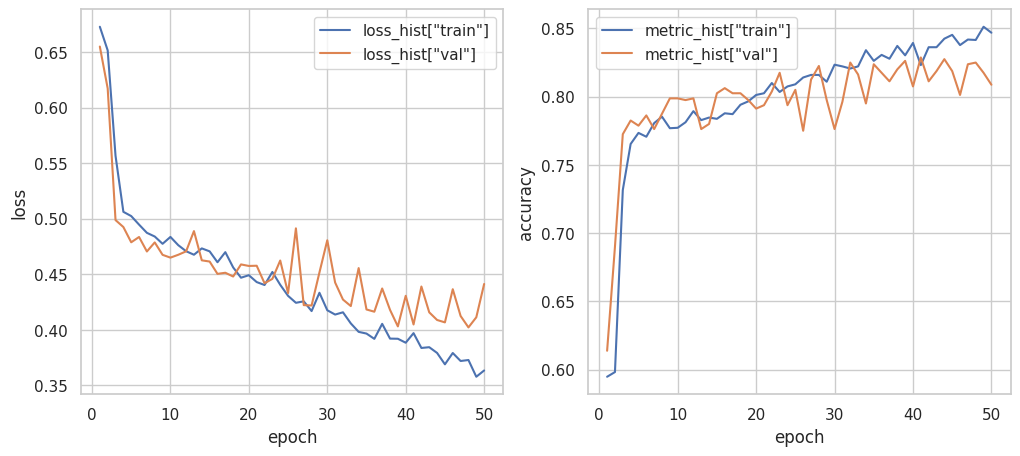

In [48]:
import seaborn as sns; sns.set(style='whitegrid')

epochs=params_train["epochs"]

fig,ax = plt.subplots(1,2,figsize=(12,5))

sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["train"],ax=ax[0],label='loss_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["val"],ax=ax[0],label='loss_hist["val"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["train"],ax=ax[1],label='metric_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["val"],ax=ax[1],label='metric_hist["val"]')

ax[0].set_xlabel("epoch")
ax[0].set_ylabel("loss")
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("accuracy")

## 6. Submission

In [33]:
class pytorchdata_test(Dataset):
    
    def __init__(self, data_dir, transform,data_type="train"):
        
        path2data = os.path.join(data_dir,data_type)
        filenames = os.listdir(path2data)
        self.full_filenames = [os.path.join(path2data, f) for f in filenames]
        
        # labels are in a csv file named train_labels.csv
        csv_filename="sample_submission.csv"
        path2csvLabels=os.path.join(data_dir,csv_filename)
        labels_df=pd.read_csv(path2csvLabels)
        
        # set data frame index to id
        labels_df.set_index("id", inplace=True)
        
        # obtain labels from data frame
        self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames]
        self.transform = transform       
        
    def __len__(self):
        # return size of dataset
        return len(self.full_filenames)
    
    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        image = Image.open(self.full_filenames[idx]) # PIL image
        image = self.transform(image)
        return image, self.labels[idx]

In [49]:
# sample submission
path_sub = "/kaggle/input/histopathologic-cancer-detection/sample_submission.csv"
labels_df = pd.read_csv(path_sub)
labels_df.head()
labels_df.shape

(57458, 2)

In [50]:
data_dir = '/kaggle/input/histopathologic-cancer-detection/'

data_transformer = transforms.Compose([transforms.ToTensor(),
                                       transforms.Resize((46,46))])

img_dataset_test = pytorchdata_test(data_dir,data_transformer,data_type="test")
print(len(img_dataset_test), 'samples found')

57458 samples found


In [51]:
def inference(model,dataset,device,num_classes=2):
    
    len_data=len(dataset)
    y_out=torch.zeros(len_data,num_classes) # initialize output tensor on CPU
    y_gt=np.zeros((len_data),dtype="uint8") # initialize ground truth on CPU
    model=model.to(device) # move model to device
    
    with torch.no_grad():
        for i in tqdm(range(len_data)):
            x,y=dataset[i]
            y_gt[i]=y
            y_out[i]=model(x.unsqueeze(0).to(device))

    return y_out.numpy(),y_gt            

In [52]:
y_test_out,_ = inference(cnn_model,img_dataset_test, device)            

  0%|          | 0/57458 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning:

The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).



In [55]:
y_test_pred

array([0, 0, 0, ..., 1, 0, 0])

In [53]:
# class predictions 0,1
y_test_pred=np.argmax(y_test_out,axis=1)
print(y_test_pred.shape)
print(y_test_pred[0:5])

(57458,)
[0 0 0 1 0]


In [54]:
# probabilities of predicted selection
# return F.log_softmax(x, dim=1) ie.
preds = np.exp(y_test_out[:, 1])
print(preds.shape)
print(preds[0:5])

(57458,)
[0.22625545 0.02891552 0.10815556 0.8536923  0.36389384]


In [57]:
output_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')

In [59]:
output_df['label'] = y_test_pred

In [60]:
output_df.to_csv("submission.csv", index = False)